In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pylightcurve as plc
import sqlite3
import random

from QhX import plots
from QhX.utils import *
from QhX.algorithms.wavelets.wwtz import *
from QhX.calculation import *


#### Light curve variability functions

In [31]:
# Set random seed for reproducibility
np.random.seed(42)

def add_cloud_modulation(time, flux, amplitude=0.001, timescale=0.2):

    # Generate smooth cloud variations using a sum of sines with different periods
    periods = np.array([0.2, 0.5, 1.0, 2.0]) * timescale * (time[-1] - time[0])
    cloud_signal = np.zeros_like(flux)

    for period in periods:
        phase = 2 * np.pi * time / period
        cloud_signal += np.sin(phase + np.random.rand() * 2 * np.pi)

    # Normalize and scale
    cloud_signal = cloud_signal / np.max(np.abs(cloud_signal)) * amplitude

    # Apply cloud modulation
    return time, flux * (1 + cloud_signal)

def add_wind_variations(time, flux, amplitude=0.0005, n_features=5):

    # Initialize wind signal
    wind_signal = np.zeros_like(flux)

    # Generate random wind features
    for _ in range(n_features):
        # Random position and width
        pos = np.random.uniform(time[0], time[-1])
        width = np.random.uniform(0.01, 0.1) * (time[-1] - time[0])

        # Add a smooth localized feature
        feature = amplitude * np.exp(-((time - pos) / width) ** 2)

        # Random direction (absorption or emission)
        if np.random.rand() > 0.5:
            feature *= -1

        wind_signal += feature

    # Apply wind variations
    return time, flux + wind_signal

def add_photochemical_cycles(time, flux, amplitude=0.0008, period_range=(0.1, 0.5)):

    # Generate several overlapping periodic signals
    total_time = time[-1] - time[0]
    n_cycles = np.random.randint(3, 7)
    photo_signal = np.zeros_like(flux)

    for _ in range(n_cycles):
        period = np.random.uniform(period_range[0], period_range[1]) * total_time
        phase = 2 * np.pi * time / period
        phase_shift = np.random.rand() * 2 * np.pi

        # Add asymmetric waveform to simulate chemical buildups and depletions
        cycle = np.sin(phase + phase_shift) + 0.3 * np.sin(2 * phase + phase_shift) - 0.1 * np.sin(3 * phase + phase_shift)

        # Normalize and add to main signal
        cycle = cycle / np.max(np.abs(cycle))
        photo_signal += cycle

    # Normalize and scale
    photo_signal = photo_signal / np.max(np.abs(photo_signal)) * amplitude

    # Apply photochemical variations
    return time, flux * (1 + photo_signal)

def add_instrument_noise(flux, noise_level=0.0003):

    noise = np.random.normal(0, noise_level, size=len(flux))
    return flux + noise

def simulate_exoplanet_transit(time, flux):

    # Add all atmospheric variations
    flux = add_cloud_modulation(time, flux, amplitude=0.001, timescale=0.2)
    flux = add_wind_variations(time, flux, amplitude=0.0005, n_features=8)
    flux = add_photochemical_cycles(time, flux, amplitude=0.0008)

    # Add instrument noise
    final_flux = add_instrument_noise(flux, noise_level=0.0003)

    return time, final_flux

In [32]:
def generate_planet(mid_time, mid_time_format):
    """Generate a planet with a given mid_time and mid_time_format."""
    # Create a planet object
    planet = plc.Planet(
    name='HD209458b',
    ra = 330.795,
    dec = 18.884,
    stellar_logg = 4.36,
    stellar_temperature = 6065.0,
    stellar_metallicity = 0.0,
    rp_over_rs = 0.12086,          # float, no units
    period = 3.5247486,            # float, in days
    sma_over_rs = 8.76,            # float, no units
    eccentricity = 0.0,            # float, no units
    inclination = 86.71,
    periastron = 0.0,
    mid_time = mid_time,
    mid_time_format = mid_time_format,
    ldc_method = 'claret',
    ldc_stellar_model = 'phoenix',
    albedo = 0.15,
    emissivity = 1.0
    )
    return planet

In [33]:
""" Picking a mid time for the transit from the baseline observation times (in MJD)"""

def pick_middle_biased(arr):
    # Get the length of the array
    arr_length = len(arr)

    # Define the mean (middle of the array)
    mean = (arr_length - 1) / 2

    # Define the standard deviation (smaller values will concentrate more around the middle)
    std_dev = arr_length / 6

    while True:
        # Generate a random index following normal distribution
        random_index = int(np.random.normal(mean, std_dev))

        # Check if the index is within array bounds
        if 0 <= random_index < arr_length:
            return arr[random_index]

In [34]:
"""Picking a sample of time instances to plot the transit light curve - since the baseline data is spread over years"""

def sample_values_within_range(array, target_value, tolerance=0.1, sample_size=200):
    # Convert input to numpy array if it's not already
    array = np.array(array)

    # Find all values within the range
    mask = np.abs(array - target_value) <= tolerance
    valid_values = array[mask]

    # Remove duplicates
    unique_values = np.unique(valid_values)

    # Check if we have enough values
    if len(unique_values) < sample_size:
        print(f"Warning: Only {len(unique_values)} unique values found within the range. Returning all available values.")
        return unique_values.tolist()

    # Sample without replacement to ensure each value appears only once
    sampled_values = random.sample(unique_values.tolist(), sample_size)

    return sampled_values

#### Generate a planet using pylightcurve

In [35]:
# define a planet
planet_1 = generate_planet(2452826.62928, 'BJD_TDB')


Fp/Fs estimated using A=0.15, e=1.0 for filter COUSINS_R.


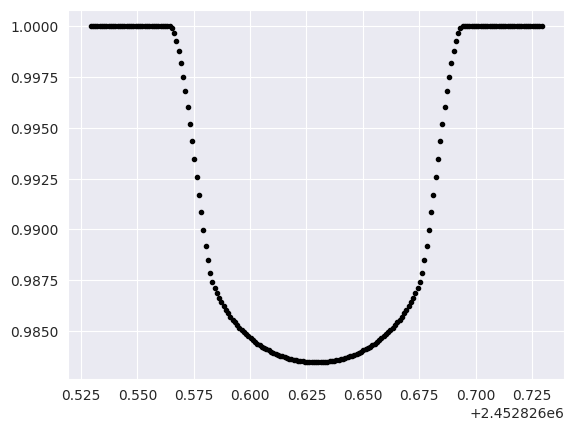

In [36]:
# simulate a light curve
time_simple = np.arange(planet_1.mid_time - 0.1, planet_1.mid_time + 0.1, 0.001)

transit_light_curve = planet_1.transit_integrated(time_simple, time_format='BJD_TDB', exp_time=120, time_stamp = 'mid', filter_name='COUSINS_R', max_sub_exp_time=1)

plt.plot(time_simple, transit_light_curve, 'ko', ms=3)


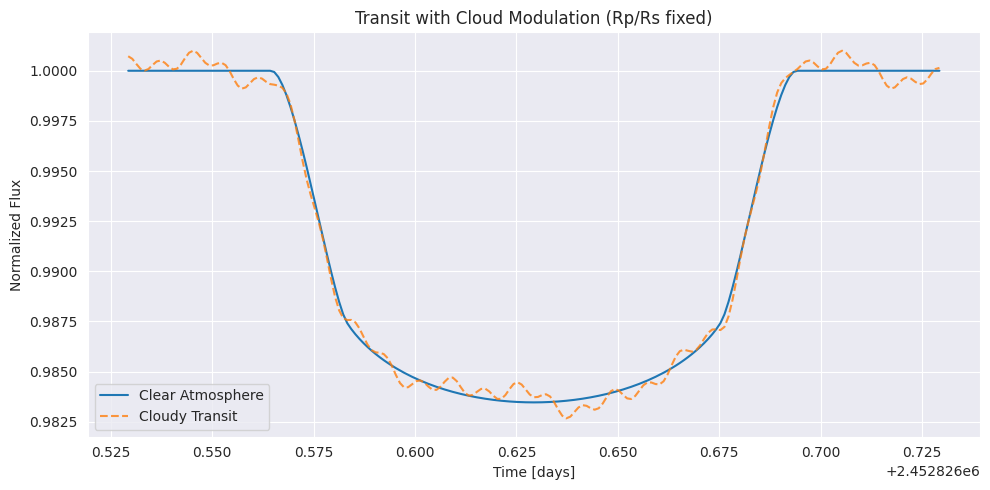

In [37]:
# Define cloud modulation (sinusoidal over time)
time_sample, flux_cloudy = add_cloud_modulation(time_simple, transit_light_curve)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time_simple, transit_light_curve, label="Clear Atmosphere")
plt.plot(time_simple, flux_cloudy, '--', label="Cloudy Transit", alpha=0.8)
plt.xlabel("Time [days]")
plt.ylabel("Normalized Flux")
plt.title("Transit with Cloud Modulation (Rp/Rs fixed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

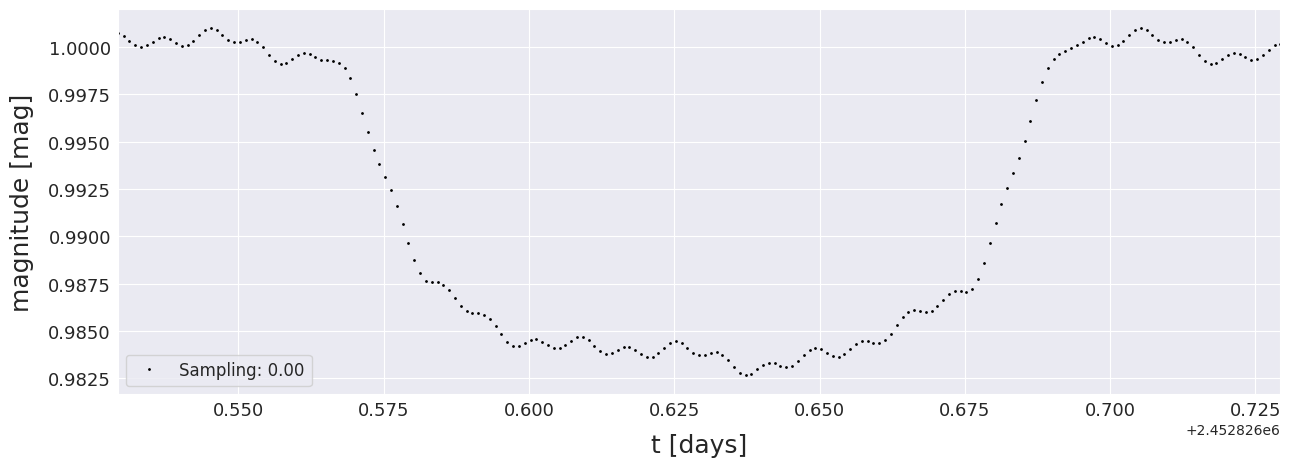

In [38]:
plots.fig_plot(time_simple, flux_cloudy, ymin = 0.001, ymax = 0.001)

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1000.0
largest tau window is  0.003
111.34 seconds has passed to complete Weighted Wavelet Z-transform 



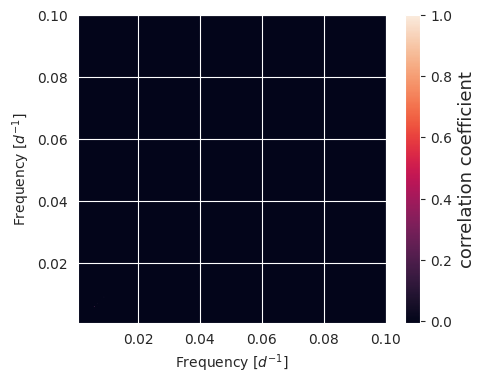

In [39]:
# Performing weighted wavelet transform

wwz_matrix, corr, extent = hybrid2d(time_simple, flux_cloudy, 80, 800, minfq=2000,maxfq=10)

plots.plt_freq_heatmap(corr, extent)

#### Define a new planet for the cadence obtained from the LSST baseline data

In [40]:
"""Importing LSST baseline data"""

# Path to your .db file
db_path = '/home/pujitha/MASS/Computational_Astrobiology/baseline_v2.0_10yrs.db'

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Name of the table and column you're interested in
table_name = 'observations'
column_name = 'observationStartMJD'

# Execute query to get all values from the specific column
cursor.execute(f"SELECT {column_name} FROM {table_name}")
rows = cursor.fetchall()

# Store the values in an array
mjd = [row[0] for row in rows]

# Close the connection
conn.close()


In [41]:
mid_time_mjd = pick_middle_biased(mjd)  # pick mid time from the baseline data


In [42]:
mjd_random = sample_values_within_range(mjd, mid_time_mjd)  # pick sample range based on the mid time from baseline data
mjd_random.sort()
mjd_random = np.array(mjd_random)

In [43]:
# define a new planet based on baseline mid time
planet_2 = generate_planet(mjd_random[100], 'MJD_UTC')


Fp/Fs estimated using A=0.15, e=1.0 for filter COUSINS_R.


Text(0.5, 1.0, 'Lightcurve generated using pylightcurve')

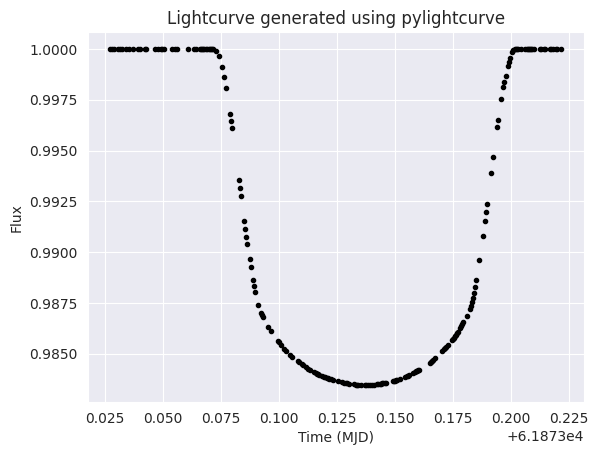

In [44]:
# transit flux for the new planet
transit_lcurve_baseline = planet_2.transit_integrated(mjd_random, time_format='MJD_UTC', exp_time=120, time_stamp = 'mid', filter_name='COUSINS_R', max_sub_exp_time=1)

plt.plot(mjd_random, transit_lcurve_baseline, 'ko', ms=3)
plt.xlabel('Time (MJD)')
plt.ylabel('Flux')
plt.title('Lightcurve generated using pylightcurve')

In [45]:
print(type(transit_lcurve_baseline))

<class 'numpy.ndarray'>


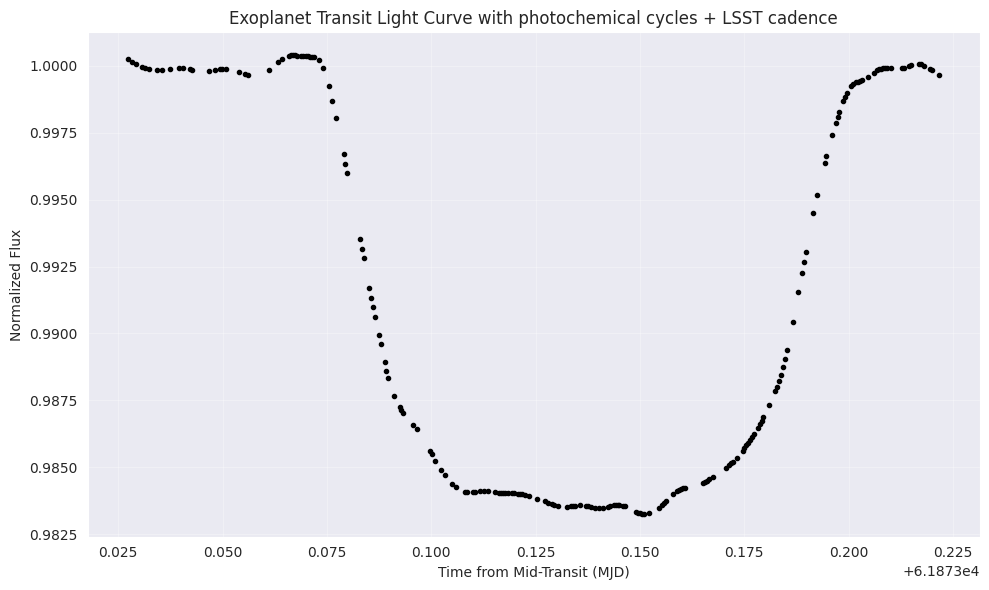

In [46]:
mjd_random_new , lcurve_db_new = add_photochemical_cycles(mjd_random, transit_lcurve_baseline)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(mjd_random_new, lcurve_db_new, 'ko', ms=3)
plt.xlabel('Time from Mid-Transit (MJD)')
plt.ylabel('Normalized Flux')
plt.title('Exoplanet Transit Light Curve with photochemical cycles + LSST cadence')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1121.098
largest tau window is  0.003
2.07 seconds has passed to complete Weighted Wavelet Z-transform 



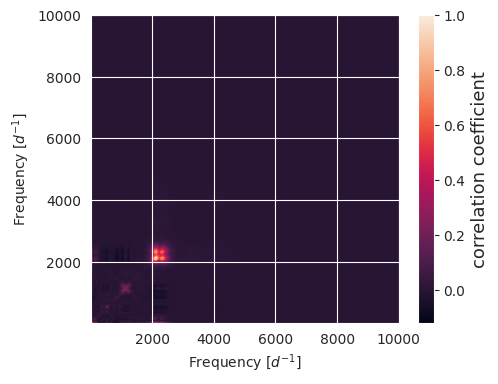

In [47]:
# Performing weighted wavelet transform

wwz_matrix_new, corr_new, extent_new = hybrid2d(mjd_random_new, lcurve_db_new, 75, 200, minfq=0.2, maxfq=0.0001)

plots.plt_freq_heatmap(corr_new, extent_new)

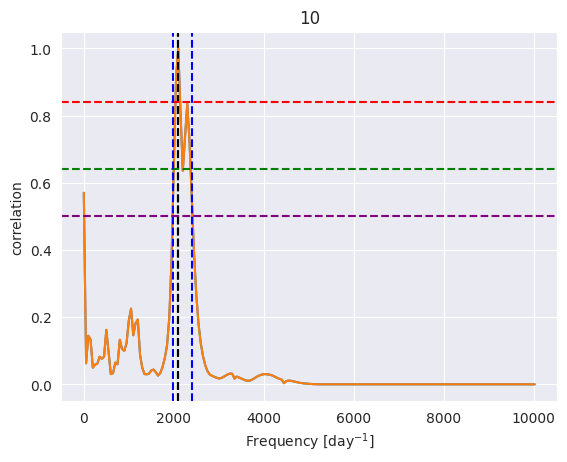

In [48]:
# Determine significance
# Assuming the use of a function like signif_johnson (though not explicitly found in the provided notebook cells)
numlc1 =10  # Example Object ID
numlc=10 #number of lc for johnson method
peak = 0  # Example peak position
idx_peaks = [0]  # Example index of peak, assuming a single peak

# Detect periods in the correlation matrix and store results in peaks0, hh0, r_periods0, up0, low0
peaks0, hh0, r_periods0, up0, low0 = periods(numlc1, corr_new, 200, plot=False, minfq=0.2, maxfq=0.0001)

# Function for calculations of periods
peaks0, hh0, r_periods0, up0, low0 = periods(10, corr_new, 200, plot=True, minfq=0.2, maxfq=0.0001)


In [49]:
# Write down obtained results
for j in range(len(r_periods0)):
    print("Period: %6.3f, upper error : %5.2f  lower error : %5.2f"% (r_periods0[j], up0[j], low0[j]) )

Period:  0.000, upper error :  0.00  lower error :  0.00


*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1121.098
largest tau window is  0.002
105.52 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1121.098
largest tau window is  0.002
105.17 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1121.098
largest tau window is  0.002
105.36 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1121.098
largest tau window is  0.002
105.77 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1121.098
largest tau window is  0.002
105.49 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Text(0.5, 1.0, 'correlation peak for artificial curves')

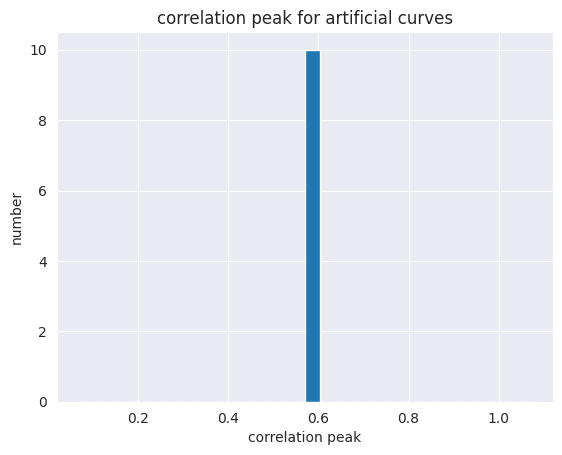

In [50]:

yax = corr_new.flatten()  # Example correlation of oscillation patterns
bins, bins11, sig, siger = signif_johnson(numlc,peak, idx_peaks, hh0, mjd_random_new, lcurve_db_new, ntau=80, ngrid=800, f=2, peakHeight=0.6, minfq=2000, maxfq=10)
plt.hist(bins,30)
bins=np.array(bins)
plt.xlabel('correlation peak')
plt.ylabel('number')
plt.title('correlation peak for artificial curves')

